In [664]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [932]:
data = pd.read_csv("train.csv")

### 1. Data understanding and cleaning

In [933]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [934]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Treating null values

Drop all columns having 80% or more null values

In [935]:
data.dropna(thresh=len(data.index) * 0.8, axis=1, inplace=True)

##### Treating few columns individually

`LotFrontage` has few NA value, meaning that there is no street connected to property, so replacing it with 0

In [936]:
data.LotFrontage.fillna(0, inplace=True)
data.LotFrontage = data.LotFrontage.astype("int64")

Similarly `MasVnrArea` has few NA value, meaning that there is no Masonry veneer area in square feet, so replacing it with 0

In [937]:
data.MasVnrArea.fillna(0, inplace=True)
data.MasVnrArea = data.MasVnrArea.astype("int64")

Replacing NA for `GarageYrBlt` with median value

In [938]:
data.GarageYrBlt.fillna(data.GarageYrBlt.median(), inplace=True)
data.GarageYrBlt = data.GarageYrBlt.astype("int64")

#### Checking for redundant feature

Few feature are having more than 99% same values, dropping those as it does not add an value

In [939]:
redundant_cols = []
for col in data.columns:
    counts = data[col].value_counts()
    count_max = counts.iloc[0]
    if count_max / len(data) * 100 > 98:
        redundant_cols.append(col)
redundant_cols

['Street',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'LowQualFinSF',
 '3SsnPorch',
 'PoolArea']

In [940]:
data.drop(redundant_cols, axis=1, inplace=True)

Dropping `Id`

In [941]:
data.drop("Id", axis=1, inplace=True)

#### Checking for outliers

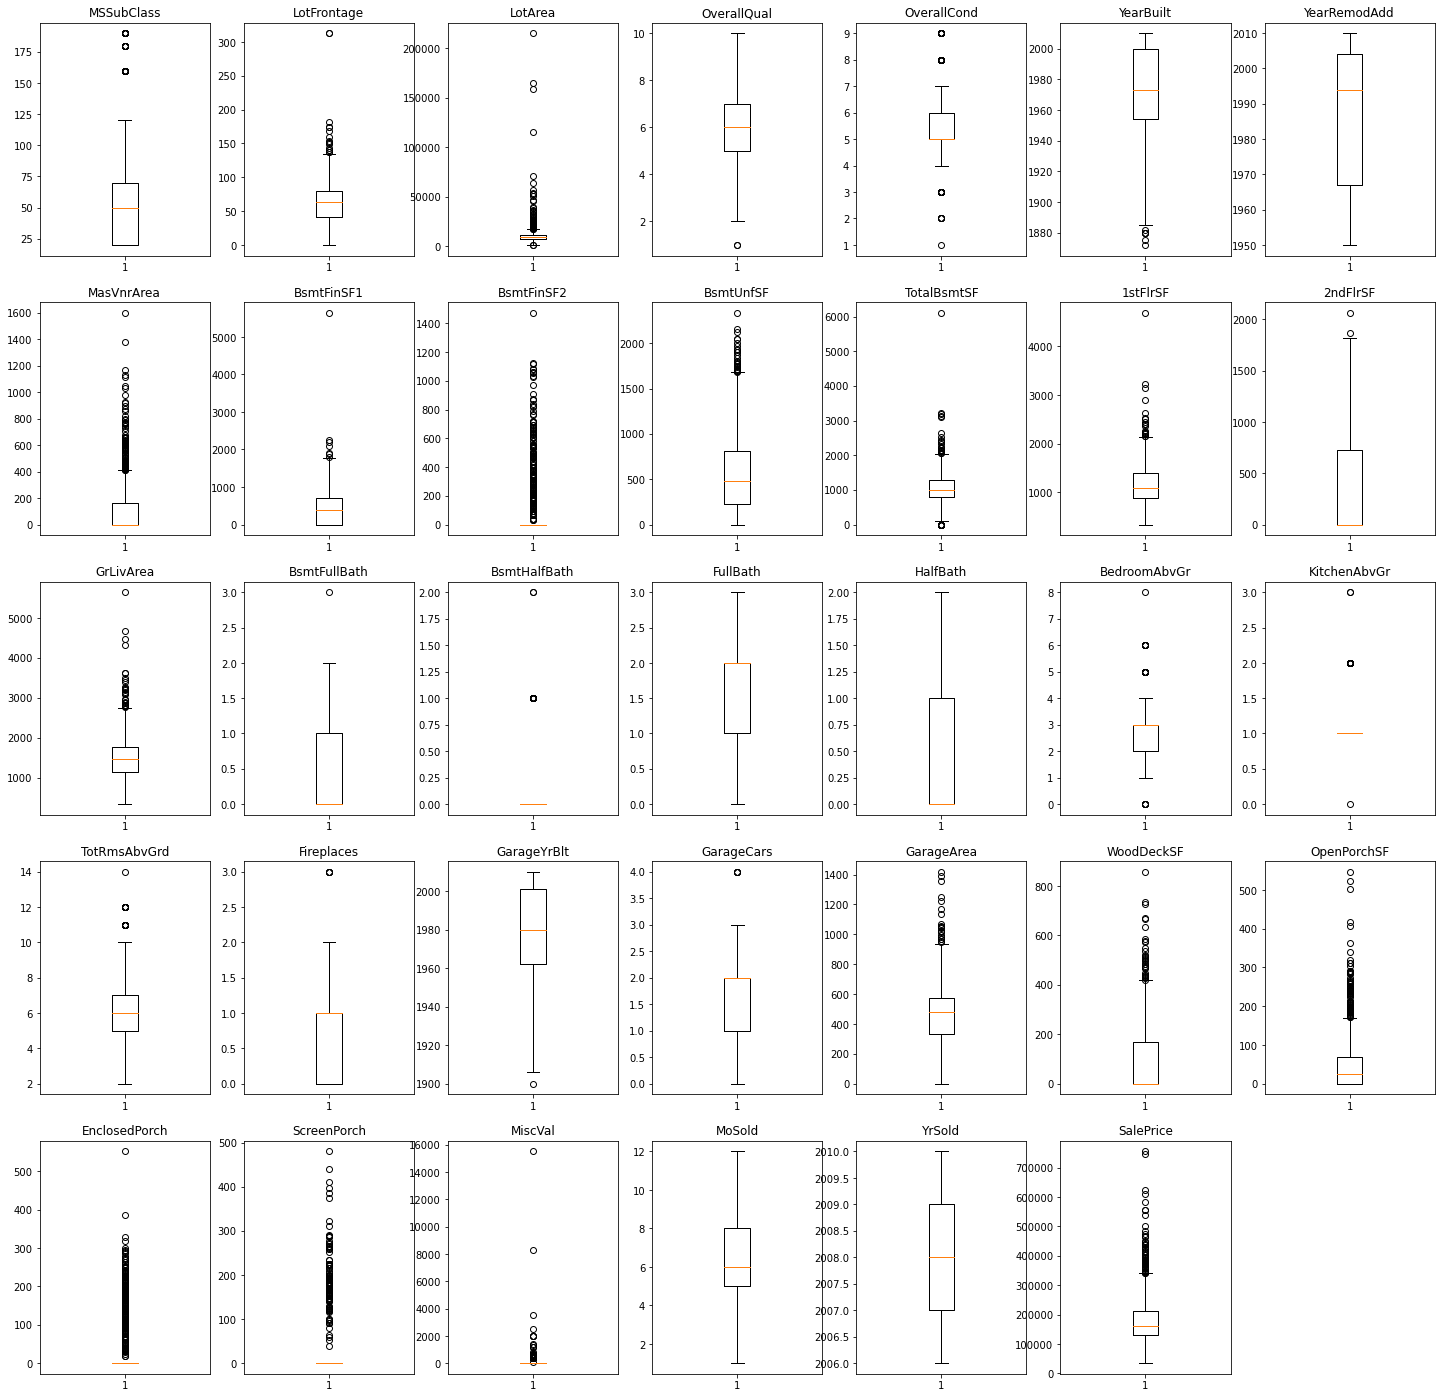

In [942]:
plt.figure(figsize=(25, 30))
for index, col_name in enumerate(data.select_dtypes('int64').columns):    
    plt.subplot(6, 7, index + 1)
    plt.boxplot(data[col_name])
    plt.title(col_name)

Let's analyze features `LotArea`, `BsmtFinSF2`, `EnclosedPorch`, `ScreenPorch`, `MiscVal`, `MiscVal`, `MasVnrArea`, `OpenPorchSF` for outliers

In [943]:
outlier_cols = ["LotArea", "BsmtFinSF2", "EnclosedPorch", "ScreenPorch", "MiscVal", "MasVnrArea", "OpenPorchSF"]
data[outlier_cols].describe([0.8, 0.9, 0.94, 0.95, 0.97, 0.98, 0.99])

,LotArea,BsmtFinSF2,EnclosedPorch,ScreenPorch,MiscVal,MasVnrArea,OpenPorchSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,46.549315,21.954110,15.060959,43.489041,103.117123,46.660274
std,9981.264932,161.319273,61.119149,55.757415,496.123024,180.731373,66.256028
min,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9478.500000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
80%,12205.800000,0.000000,0.000000,0.000000,0.000000,205.200000,83.200000
90%,14381.700000,117.200000,112.000000,0.000000,0.000000,335.000000,130.000000
94%,16551.900000,334.920000,162.920000,142.460000,0.000000,425.000000,163.840000
95%,17401.150000,396.200000,180.150000,160.000000,0.000000,456.000000,175.050000
97%,21571.800000,546.230000,216.000000,192.000000,400.000000,573.690000,213.230000


For features `LotArea`, `MasVnrArea`, `OpenPorchSF` it is safe drop values above 98 percentile

In [944]:
rem_98 = ["LotArea", "MasVnrArea", "OpenPorchSF"]
for col in rem_98:
    data = data[data[col] < data[col].quantile(0.98)]

Feature `ScreenPorch`, `MiscVal`, `BsmtFinSF2`, `EnclosedPorch` has more than 90% values as 0

In [945]:
del_cols = ["ScreenPorch", "MiscVal", "BsmtFinSF2", "EnclosedPorch"]
for col in del_cols:
    data.drop(col, inplace=True, axis=1)

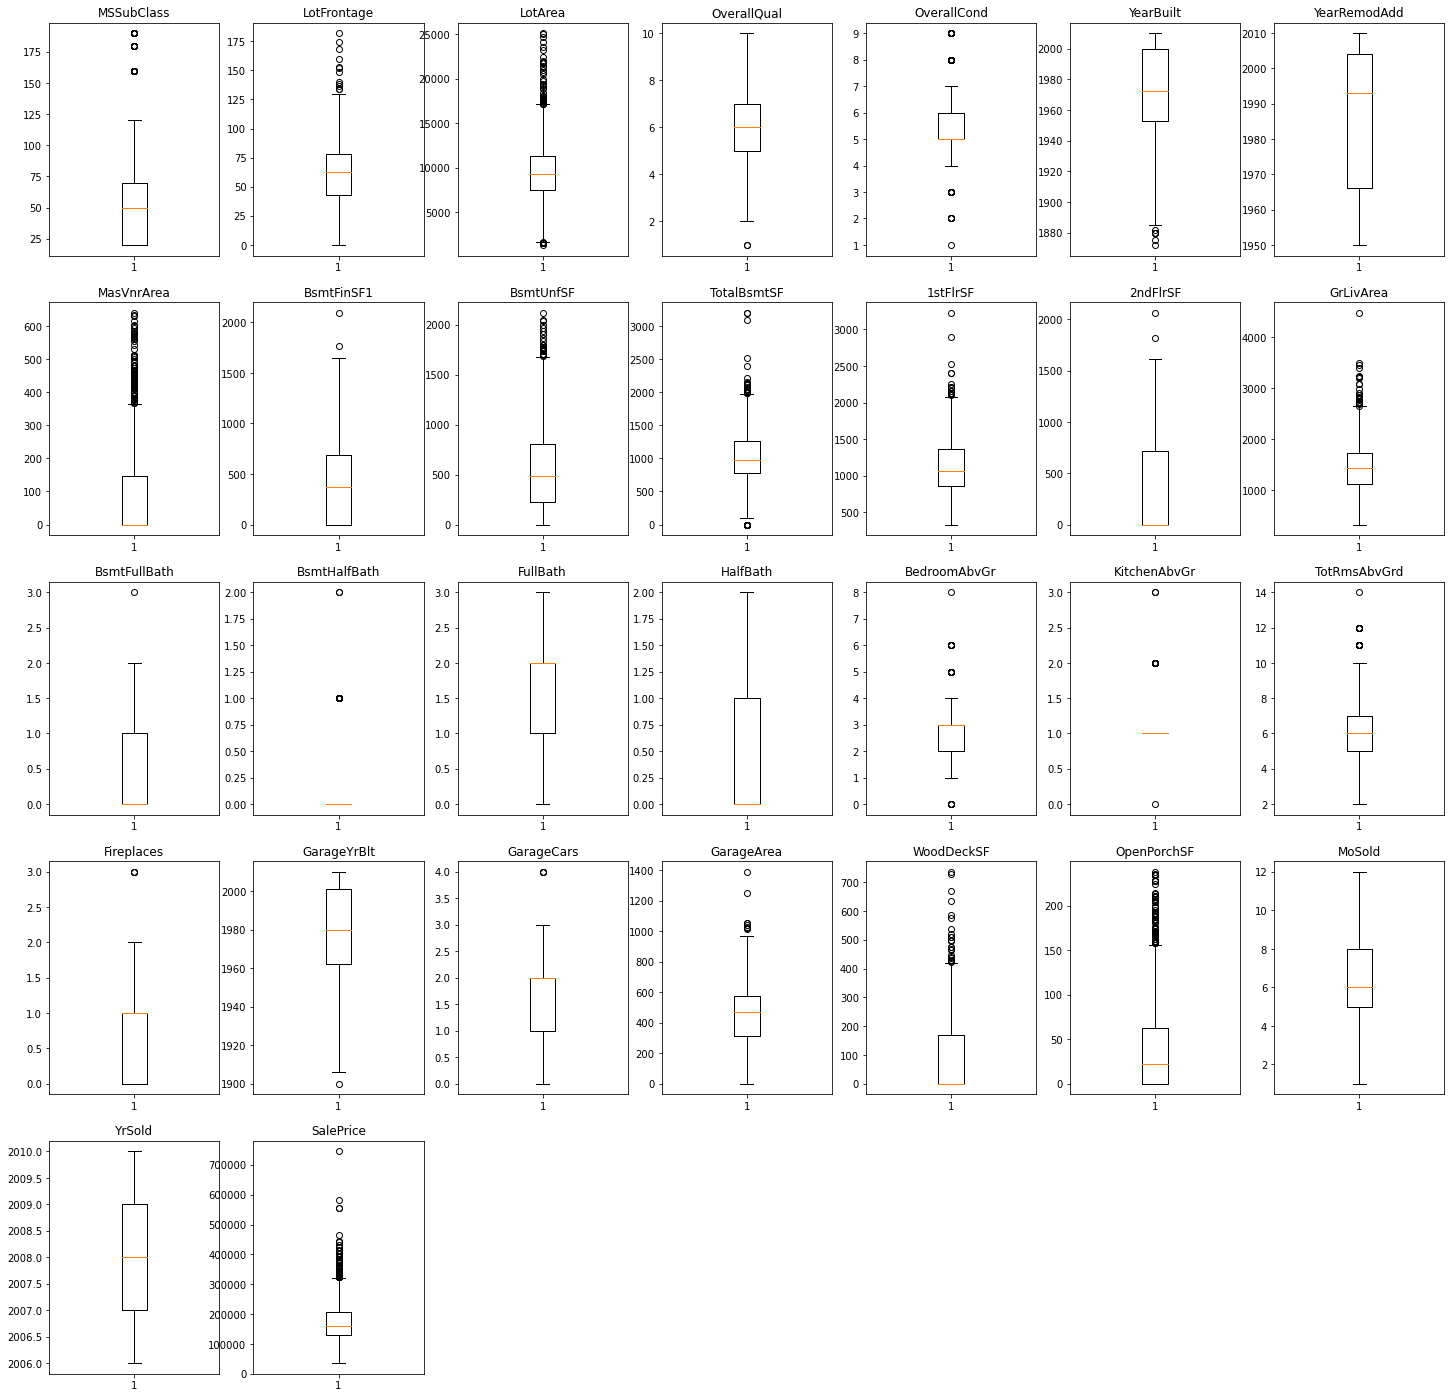

In [946]:
plt.figure(figsize=(25, 30))
for index, col_name in enumerate(data.select_dtypes('int64').columns):    
    plt.subplot(6, 7, index + 1)
    plt.boxplot(data[col_name])
    plt.title(col_name)

#### Let's analyse our target variable `SalePrice`

In [947]:
data["SalePrice"].describe([0.9, 0.95, 0.97, 0.98, 0.99])

count      1372.000000
mean     175150.526968
std       71323.799593
min       35311.000000
50%      159500.000000
90%      269350.000000
95%      315000.000000
97%      337175.000000
98%      371761.920000
99%      397416.010000
max      745000.000000
Name: SalePrice, dtype: float64

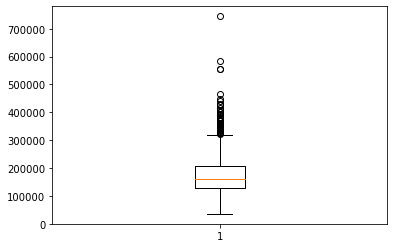

In [948]:
plt.boxplot(data["SalePrice"])
plt.show()

Keeping 95% of the saleprice

In [949]:
data = data[data["SalePrice"] <= data["SalePrice"].quantile(0.95)]

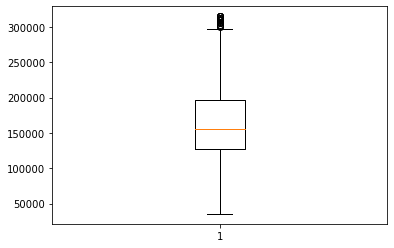

In [950]:
plt.boxplot(data["SalePrice"])
plt.show()

#### Analyzing relationship between dependent and independent numeric variable

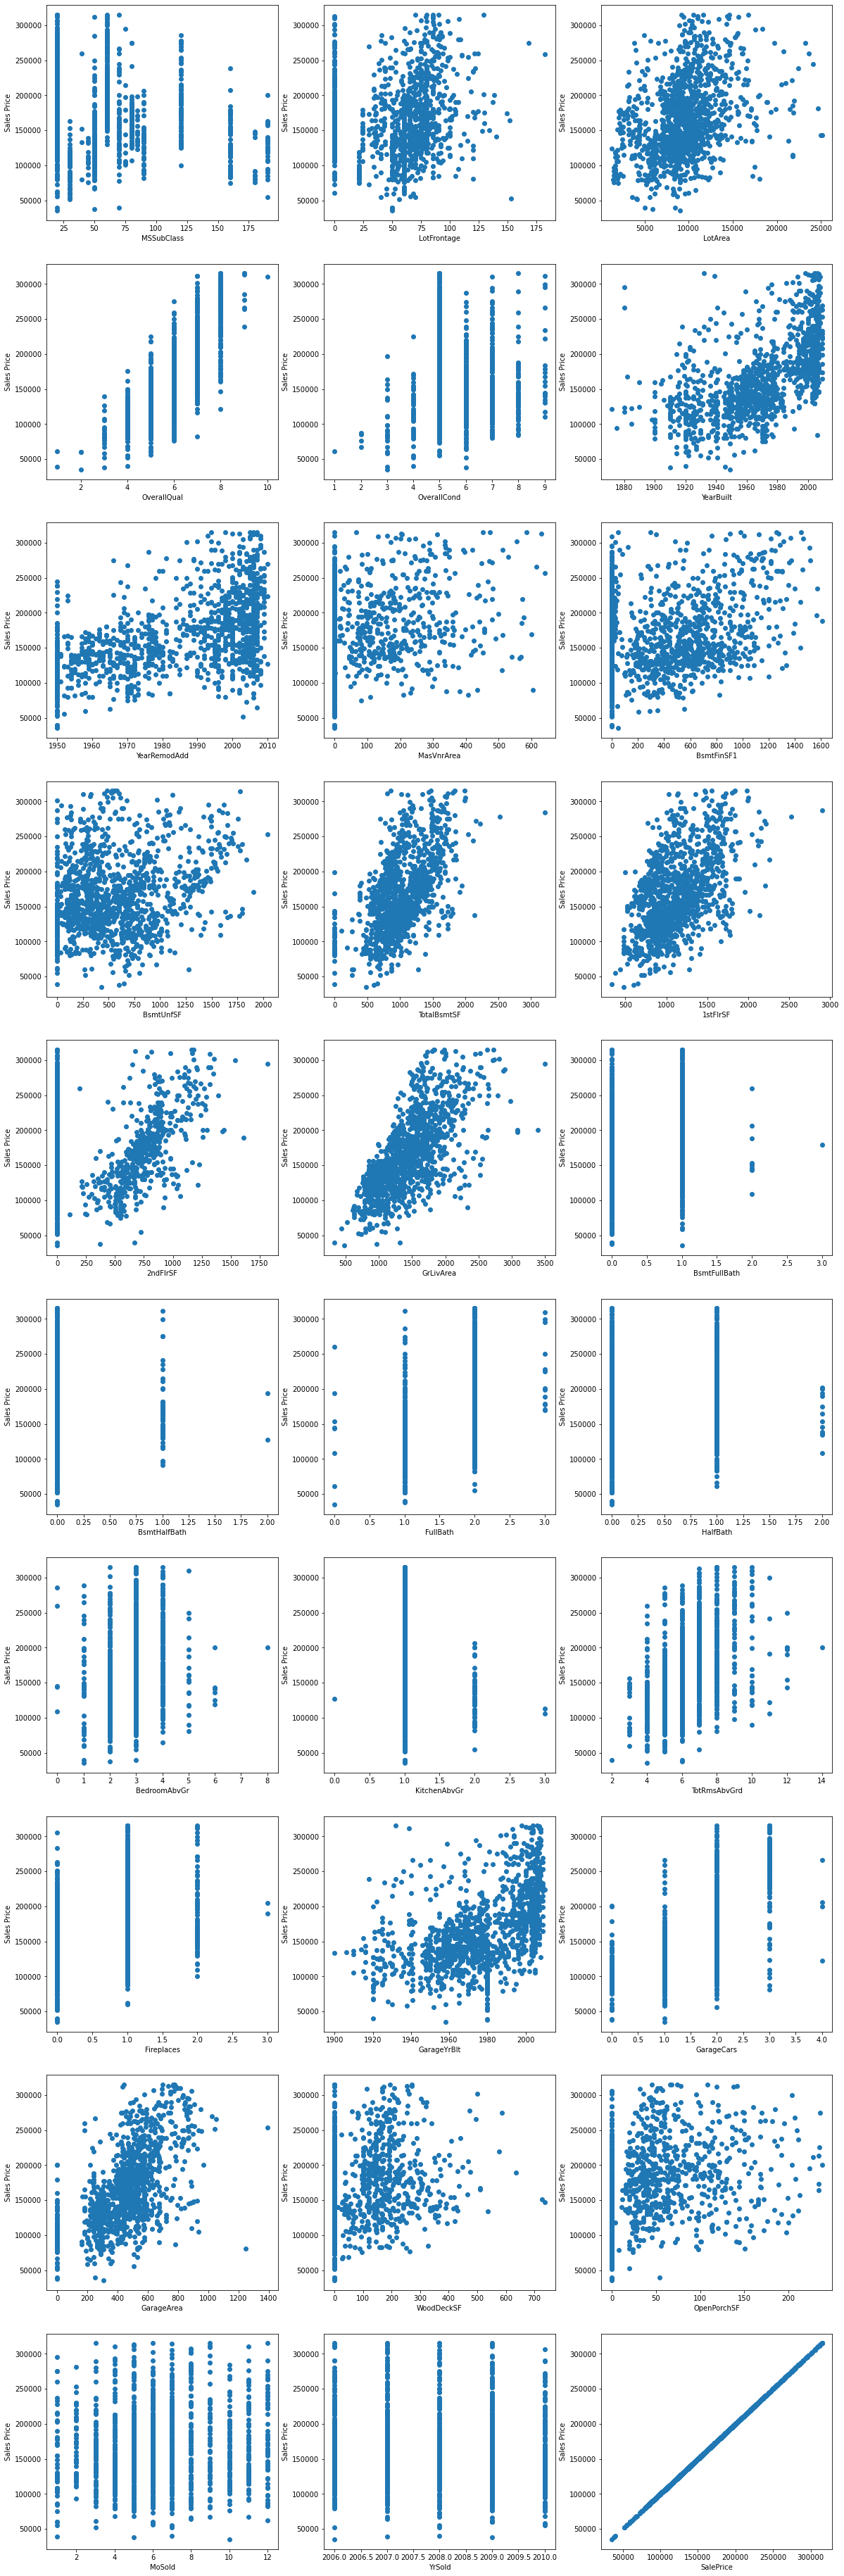

In [951]:
plt.figure(figsize=(20, 80))
for index, col_name in enumerate(data.select_dtypes('int64').columns):    
    plt.subplot(12, 3, index + 1)
    plt.scatter(data[col_name], data.SalePrice)
    plt.xlabel(col_name)
    plt.ylabel("Sales Price")

From here we can derive few ovservations like:
- With increase in overall condition the sales price increases
- There is a slight linear relationship between year built and sales price
- Similarly garage area show a linear relationship

## 2. Data preparation

#### Creating dummies

Creating dummeis for categorical variables in group of 5, as creating all toghether will be very slow

In [952]:
cat_cols = data.select_dtypes('object').columns
len(cat_cols)

34

In [953]:
data.shape

(1305, 64)

In [954]:
dummies_1 = pd.DataFrame([])
for index in range(0, 5):
    temp = pd.get_dummies(data[cat_cols[index]], prefix=cat_cols[index], drop_first=True)
    dummies_1 = pd.concat([dummies_1, temp], axis=1)

In [955]:
dummies_2 = pd.DataFrame([])
for index in range(5, 10):
    temp = pd.get_dummies(data[cat_cols[index]], prefix=cat_cols[index], drop_first=True)
    dummies_2 = pd.concat([dummies_2, temp], axis=1)

In [956]:
dummies_3 = pd.DataFrame([])
for index in range(10, 15):
    temp = pd.get_dummies(data[cat_cols[index]], prefix=cat_cols[index], drop_first=True)
    dummies_3 = pd.concat([dummies_3, temp], axis=1)

In [957]:
dummies_4 = pd.DataFrame([])
for index in range(20, 25):
    temp = pd.get_dummies(data[cat_cols[index]], prefix=cat_cols[index], drop_first=True)
    dummies_4 = pd.concat([dummies_4, temp], axis=1)

In [958]:
dummies_5 = pd.DataFrame([])
for index in range(25, 30):
    temp = pd.get_dummies(data[cat_cols[index]], prefix=cat_cols[index], drop_first=True)
    dummies_5 = pd.concat([dummies_5, temp], axis=1)

In [959]:
dummies_6 = pd.DataFrame([])
for index in range(30, 34):
    temp = pd.get_dummies(data[cat_cols[index]], prefix=cat_cols[index], drop_first=True)
    dummies_6 = pd.concat([dummies_6, temp], axis=1)

Lets drop the orginal categorical variables

In [960]:
data.drop(cat_cols, axis=1, inplace=True)

In [961]:
data = pd.concat([data, dummies_1, dummies_2, dummies_3, dummies_4, dummies_5, dummies_6], axis=1)

In [962]:
data.shape

(1305, 189)

#### Data spiltting and scaling

Let's split the test and trains data

In [963]:
data_train, data_test = train_test_split(data, test_size=0.3, random_state=1)

In [964]:
data_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1285,50,50,6000,6,6,1939,1950,0,0,780,...,0,0,0,0,1,0,0,0,1,0
1280,20,67,9808,7,5,2002,2002,110,788,785,...,0,0,0,0,1,0,0,0,1,0
418,50,60,8160,5,6,1940,1950,0,312,444,...,0,0,0,0,1,1,0,0,0,0
1428,30,60,7200,5,7,1940,1992,294,510,278,...,0,0,0,0,1,0,0,0,0,0
915,160,21,2001,4,5,1970,1970,80,0,546,...,0,0,0,0,1,0,0,0,1,0


Scaling the numeric features

In [965]:
scaler = MinMaxScaler()

In [966]:
numeric_col = data_train.select_dtypes("int").columns
data_train[numeric_col] = scaler.fit_transform(data_train[numeric_col])

In [967]:
data_test[numeric_col] = scaler.transform(data_test[numeric_col])

In [968]:
data_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,...,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000,913.000000
mean,0.225855,0.300422,0.334524,0.490416,0.516195,0.708939,0.567616,0.120258,0.247163,0.277285,...,0.002191,0.004381,0.060241,0.001095,0.891566,0.003286,0.006572,0.016429,0.836802,0.062432
std,0.258706,0.181933,0.146945,0.152118,0.158631,0.222651,0.342176,0.197049,0.244976,0.212338,...,0.046778,0.066081,0.238063,0.033095,0.311098,0.057260,0.080844,0.127189,0.369749,0.242070
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.197802,0.248245,0.375000,0.428571,0.582090,0.266667,0.000000,0.000000,0.109696,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.176471,0.329670,0.331834,0.500000,0.428571,0.723881,0.700000,0.000000,0.218555,0.238492,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.323529,0.417582,0.410801,0.625000,0.571429,0.925373,0.883333,0.195312,0.412204,0.394711,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [969]:
data_test.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,...,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,0.207983,0.317350,0.341391,0.487564,0.509475,0.698123,0.536267,0.117486,0.241253,0.264385,...,0.005102,0.002551,0.058673,0.005102,0.882653,0.002551,0.010204,0.012755,0.849490,0.061224
std,0.235059,0.164145,0.158672,0.158810,0.164473,0.225367,0.356257,0.207123,0.232266,0.201154,...,0.071337,0.050508,0.235313,0.071337,0.322245,0.050508,0.100627,0.112359,0.358028,0.240048
min,0.000000,0.000000,0.007439,-0.125000,-0.142857,-0.022388,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.274725,0.260023,0.375000,0.428571,0.559701,0.216667,0.000000,0.000000,0.099167,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.176471,0.346154,0.326749,0.500000,0.428571,0.708955,0.641667,0.000000,0.220423,0.226249,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.294118,0.417582,0.410307,0.625000,0.571429,0.925373,0.883333,0.187500,0.412360,0.390916,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,0.769231,0.982643,0.875000,1.000000,1.000000,0.983333,0.984375,0.852428,0.836925,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [970]:
y_train = np.array(data_train.pop("SalePrice")).reshape(-1, 1)
X_train = data_train

In [971]:
y_test = np.array(data_test.pop("SalePrice")).reshape(-1, 1)
X_test = data_test

### 3. Feature selection and model building

##### Feature selection

In [972]:
len(X_train.columns)

188

We will user GridSearchCrossValidation to get the optimal number of features. Lets check for 20 to 50 features as the more wider range will take exponentially more time to generate the model

In [973]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
hyper_params = [{'n_features_to_select': list(range(20, 50))}]

lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [20, 21, 22, 23, 24, 25, 26,
                                                   27, 28, 29, 30, 31, 32, 33,
                                                   34, 35, 36, 37, 38, 39, 40,
                                                   41, 42, 43, 44, 45, 46, 47,
                                                   48, 49]}],
             return_train_score=True, scoring='r2', verbose=1)

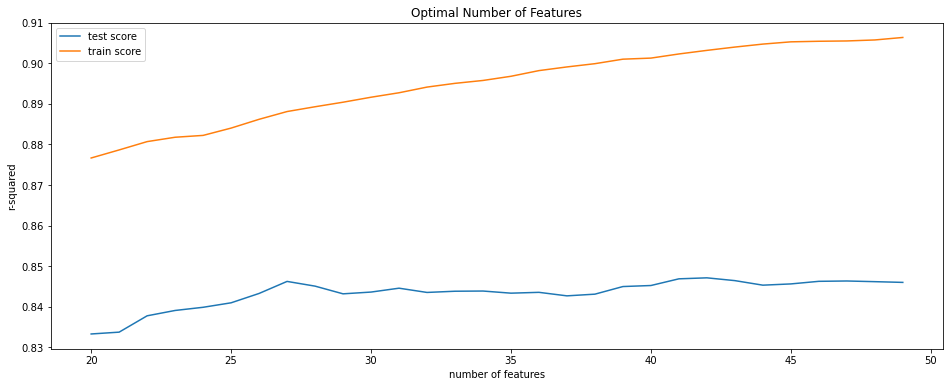

In [974]:
cv_results = pd.DataFrame(model_cv.cv_results_)

plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
plt.show()

In [975]:
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.377611,0.012040,0.001977,0.000010,20,{'n_features_to_select': 20},0.806973,0.859883,0.827112,0.847405,...,0.833273,0.018472,30,0.877714,0.876120,0.872446,0.882440,0.874553,0.876655,0.003377
1,0.369397,0.002382,0.001961,0.000019,21,{'n_features_to_select': 21},0.808694,0.859330,0.827141,0.851052,...,0.833724,0.018729,29,0.878366,0.877041,0.872673,0.884663,0.880461,0.878641,0.003945
2,0.369130,0.001992,0.001972,0.000022,22,{'n_features_to_select': 22},0.806913,0.860757,0.825830,0.851655,...,0.837751,0.019235,28,0.878428,0.880107,0.874474,0.884982,0.885466,0.880691,0.004131
3,0.367533,0.002674,0.001962,0.000020,23,{'n_features_to_select': 23},0.805489,0.869227,0.830929,0.852016,...,0.839068,0.021321,27,0.879344,0.883471,0.875276,0.885098,0.885646,0.881767,0.003926
4,0.366634,0.002013,0.001977,0.000023,24,{'n_features_to_select': 24},0.805171,0.868798,0.833465,0.854124,...,0.839851,0.021400,26,0.879972,0.883604,0.876091,0.885299,0.886140,0.882221,0.003725


The test score is almost constant after 40. 42 is having highest test score

##### Building a model

In [976]:
lm  = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=42)
rfe = rfe.fit(X_train, y_train)

### 4. Evaluating model and validating assumption

In [1020]:
y_pred_train = rfe.predict(X_train)
y_pred_test = rfe.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 Score (Train): ", round(r2_train_lr, 4))
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 Score (Test): ", round(r2_test_lr, 4))
metric.append(r2_test_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE (Train): ", round(mse_train_lr, 4))
metric.append(mse_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE (Test): ", round(mse_test_lr, 4))
metric.append(mse_test_lr)

R2 Score (Train):  0.903
R2 Score (Test):  0.8861
MSE (Train):  0.0037
MSE (Test):  0.0044


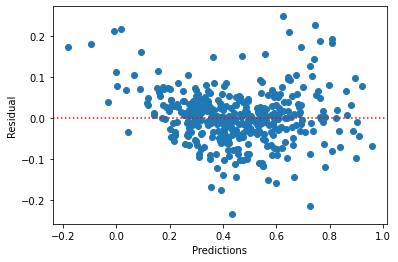

In [1021]:
plt.scatter( y_pred_test , y_test - y_pred_test)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.show()

There are no visible patterns and also the variance is fairly constant

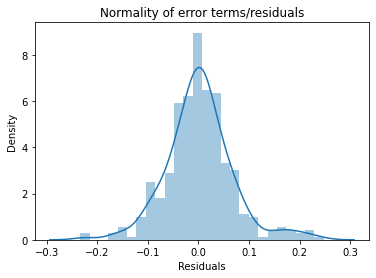

In [1022]:
p = sns.distplot(y_test - y_pred_test, kde=True)
p = plt.title('Normality of error terms/residuals')
plt.xlabel("Residuals")
plt.show()

The residuals are normally distributed

### 5. Regularization

#### Ridge regression

In [1023]:
ridge = Ridge()

folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = {'alpha': [0.1, 0.4, 0.6, 0.8, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0 ]}, 
                        scoring= 'r2',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 0.4, 0.6, 0.8, 1.0, 2.0, 4.0, 6.0, 8.0,
                                   10.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [1024]:
cv_results = pd.DataFrame(model_cv.cv_results_)

In [1025]:
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005456,0.000698,0.002838,0.000442,0.1,{'alpha': 0.1},0.869754,0.880660,0.845927,0.855999,...,0.857697,0.015991,10,0.931427,0.930002,0.933481,0.931539,0.937529,0.932795,0.002613
1,0.004154,0.000440,0.002028,0.000262,0.4,{'alpha': 0.4},0.876770,0.886719,0.857392,0.872670,...,0.868654,0.013369,9,0.930189,0.928757,0.932124,0.929667,0.935954,0.931338,0.002557
2,0.003521,0.000230,0.001799,0.000025,0.6,{'alpha': 0.6},0.880084,0.888963,0.860546,0.876385,...,0.872068,0.012764,8,0.929363,0.927975,0.931349,0.928670,0.934980,0.930467,0.002522
3,0.003381,0.000023,0.001775,0.000009,0.8,{'alpha': 0.8},0.882584,0.890653,0.862549,0.878631,...,0.874405,0.012421,6,0.928558,0.927226,0.930649,0.927795,0.934078,0.929661,0.002495
4,0.003504,0.000160,0.001805,0.000052,1.0,{'alpha': 1.0},0.884492,0.891978,0.863936,0.880121,...,0.876111,0.012207,4,0.927778,0.926500,0.929997,0.926997,0.933232,0.928901,0.002474


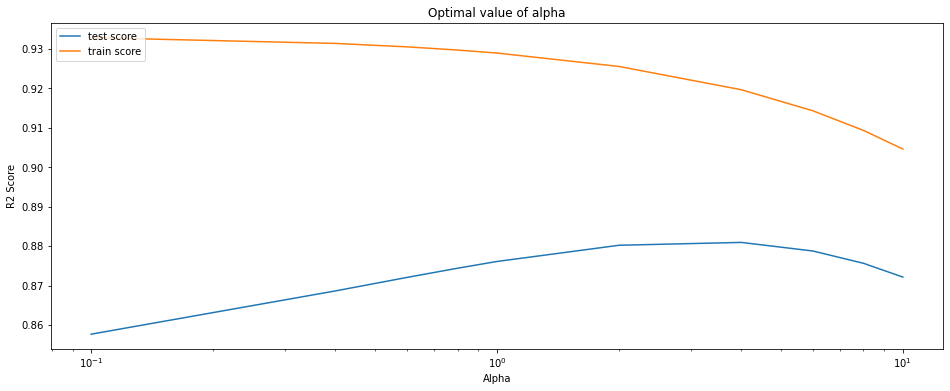

In [1026]:
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_alpha"], cv_results["mean_test_score"])
plt.plot(cv_results["param_alpha"], cv_results["mean_train_score"])
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.title("Optimal value of alpha")
plt.legend(['test score', 'train score'], loc='upper left')
plt.show()

In [1027]:
print(model_cv.best_params_)

{'alpha': 4.0}


Let's use alpha as 4.0

In [1028]:
alpha = 4
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

Ridge(alpha=4)

In [1029]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 Score (Train): ", round(r2_train_lr, 4))
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 Score (Test): ", round(r2_test_lr, 4))
metric2.append(r2_test_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE (Train): ", round(mse_train_lr, 4))
metric2.append(mse_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE (Test): ", round(mse_test_lr, 4))
metric2.append(mse_test_lr)

R2 Score (Train):  0.9177
R2 Score (Test):  0.91
MSE (Train):  0.0031
MSE (Test):  0.0035


#### Lasso regression

In [1030]:
lasso = Lasso()

model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0]}, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.1, 0.2, 0.4, 0.6,
                                   0.8, 1.0, 2.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [1031]:
cv_results = pd.DataFrame(model_cv.cv_results_)

In [1032]:
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.058297,0.014406,0.002405,0.000428,0.00001,{'alpha': 1e-05},0.870410,0.882152,0.845945,8.431765e-01,...,0.854840,0.018449,3,0.931403,0.930038,0.933495,0.931823,0.937616,0.932875,0.002615
1,0.031249,0.007534,0.001743,0.000021,0.0001,{'alpha': 0.0001},0.885564,0.897773,0.871934,8.900373e-01,...,0.881068,0.013459,1,0.925308,0.923569,0.926658,0.924016,0.930678,0.926046,0.002555
2,0.004968,0.000271,0.001746,0.000024,0.001,{'alpha': 0.001},0.864469,0.881264,0.874809,8.643380e-01,...,0.868902,0.007926,2,0.890428,0.884714,0.891049,0.887414,0.893703,0.889462,0.003104
3,0.003219,0.000007,0.001786,0.000012,0.1,{'alpha': 0.1},-0.000978,-0.000591,-0.000020,-7.053292e-07,...,-0.000332,0.000390,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.003690,0.000367,0.001884,0.000081,0.2,{'alpha': 0.2},-0.000978,-0.000591,-0.000020,-7.053292e-07,...,-0.000332,0.000390,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


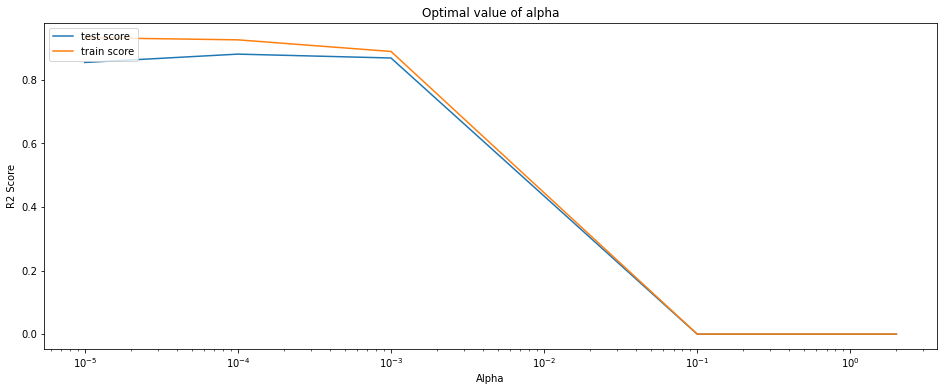

In [1033]:
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_alpha"], cv_results["mean_test_score"])
plt.plot(cv_results["param_alpha"], cv_results["mean_train_score"])
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.title("Optimal value of alpha")
plt.legend(['test score', 'train score'], loc='upper left')
plt.show()

In [1034]:
print(model_cv.best_params_)

{'alpha': 0.0001}


Let's use alpha as 0.001

In [1035]:
alpha =0.0001
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [1036]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 Score (Train): ", round(r2_train_lr, 4))
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 Score (Test): ", round(r2_test_lr, 4))
metric3.append(r2_test_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE (Train): ", round(mse_train_lr, 4))
metric3.append(mse_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE (Test): ", round(mse_test_lr, 4))
metric3.append(mse_test_lr)

R2 Score (Train):  0.921
R2 Score (Test):  0.9111
MSE (Train):  0.003
MSE (Test):  0.0034


#### Comparision

In [1038]:
lr_table = {
    'Metric': ['R2 Score (Train)','R2 Score (Test)', 'MSE (Train)','MSE (Test)'],
    'Linear Regression': metric
}

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.902975,0.917658,0.920974
1,R2 Score (Test),0.886095,0.909955,0.911112
2,MSE (Train),0.003687,0.003129,0.003003
3,MSE (Test),0.004382,0.003464,0.003419


In [1039]:
ridge_params = list(ridge.coef_[0])
ridge_params.insert(0,ridge.intercept_)

cols = data_train.columns
cols.insert(0,'constant')

coefs = pd.DataFrame(list(zip(cols, ridge_params)))
coefs.columns = ['Feaure','Coef']

coefs.sort_values(by='Coef',ascending=False).head(10)

,Feaure,Coef
4,OverallCond,0.177514
14,BsmtFullBath,0.158376
12,2ndFlrSF,0.132886
9,BsmtUnfSF,0.106383
11,1stFlrSF,0.099609
3,OverallQual,0.097416
13,GrLivArea,0.07795
5,YearBuilt,0.072816
6,YearRemodAdd,0.068456
25,WoodDeckSF,0.066429


In [1040]:
lasso_params = list(lasso.coef_)
lasso_params.insert(0,lasso.intercept_[0])

cols = data_train.columns
cols.insert(0,'constant')

coefs = pd.DataFrame(list(zip(cols, lasso_params)))
coefs.columns = ['Feaure','Coef']

coefs.sort_values(by='Coef',ascending=False).head(10)

,Feaure,Coef
14,BsmtFullBath,0.412989
4,OverallCond,0.241747
11,1stFlrSF,0.135308
6,YearRemodAdd,0.122261
3,OverallQual,0.112172
5,YearBuilt,0.096480
9,BsmtUnfSF,0.091181
24,GarageArea,0.068852
158,GarageType_Attchd,0.067541
67,Neighborhood_Timber,0.067411


### Conclusion

1. Optimal Alphas
    -  For ridge regression: 4
    -  For lasso regression: 0.0001
2. Feature that best define the models are:
    - OverallCond: Rates the overall condition of the house
    - YearBuilt: Original construction date
    - BsmtFullBath: Basement full bathrooms
    - GarageArea: Size of garage in square feet
    - 1stFlrSF: First Floor square feet
    - YearRemodAdd: Remodel date
    - OverallQual: Rates the overall material and finish of the house
    - BsmtUnfSF: Unfinished square feet of basement area

## Subjective Question

### Question 1

#### Doubling alpha for Ridge regression

In [1041]:
alpha = 8
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

Ridge(alpha=8)

Analyzing the result

In [1042]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 Score (Train): ", round(r2_train_lr, 4))

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 Score (Test): ", round(r2_test_lr, 4))

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE (Train): ", round(mse_train_lr, 4))

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE (Test): ", round(mse_test_lr, 4))

R2 Score (Train):  0.9096
R2 Score (Test):  0.9028
MSE (Train):  0.0034
MSE (Test):  0.0037


In [1043]:
ridge_params = list(ridge.coef_[0])
ridge_params.insert(0,ridge.intercept_)

cols = data_train.columns
cols.insert(0,'constant')

coefs = pd.DataFrame(list(zip(cols, ridge_params)))
coefs.columns = ['Feaure','Coef']

coefs.sort_values(by='Coef',ascending=False).head(10)

,Feaure,Coef
4,OverallCond,0.14922
14,BsmtFullBath,0.133575
12,2ndFlrSF,0.112319
9,BsmtUnfSF,0.101844
11,1stFlrSF,0.087729
3,OverallQual,0.084024
25,WoodDeckSF,0.066441
13,GrLivArea,0.064381
24,GarageArea,0.064366
21,Fireplaces,0.059508


#### Doubling alpha for Lasso regression

In [1044]:
alpha =0.0002
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0002)

In [1045]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 Score (Train): ", round(r2_train_lr, 4))

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 Score (Test): ", round(r2_test_lr, 4))

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE (Train): ", round(mse_train_lr, 4))

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE (Test): ", round(mse_test_lr, 4))

R2 Score (Train):  0.9162
R2 Score (Test):  0.91
MSE (Train):  0.0032
MSE (Test):  0.0035


In [1046]:
lasso_params = list(lasso.coef_)
lasso_params.insert(0,lasso.intercept_[0])

cols = data_train.columns
cols.insert(0,'constant')

coefs = pd.DataFrame(list(zip(cols, lasso_params)))
coefs.columns = ['Feaure','Coef']

coefs.sort_values(by='Coef',ascending=False).head(10)

,Feaure,Coef
14,BsmtFullBath,0.434021
4,OverallCond,0.257981
11,1stFlrSF,0.116751
6,YearRemodAdd,0.111505
3,OverallQual,0.104172
9,BsmtUnfSF,0.093742
5,YearBuilt,0.090535
51,Neighborhood_Edwards,0.068406
24,GarageArea,0.062794
61,Neighborhood_OldTown,0.058646


### Question 2

In [1005]:
lasso.coef_

array([-1.08916938e-02, -7.59692231e-03,  1.12172009e-01,  2.41747031e-01,
        9.64795637e-02,  1.22260712e-01,  2.96100849e-02,  6.71250941e-03,
        9.11814110e-02, -0.00000000e+00,  1.35308125e-01,  4.34267373e-02,
        1.90648384e-02,  4.12988753e-01,  4.10787183e-02,  2.17741167e-03,
        0.00000000e+00,  6.68593893e-03, -9.10184054e-03, -5.52866188e-02,
        0.00000000e+00,  2.98670300e-02,  1.35972277e-02,  6.88521012e-02,
        4.79218256e-02,  2.75282836e-02,  1.47776761e-02,  2.14887726e-03,
       -7.95880133e-03,  1.84944373e-02,  3.67027573e-03,  2.21143075e-02,
        0.00000000e+00,  3.92798487e-03,  7.23139584e-03,  8.19967931e-04,
        8.01174874e-03, -6.94393060e-03,  2.45302584e-03,  1.67546716e-02,
       -2.28480174e-02, -0.00000000e+00, -1.58774957e-03,  9.37057392e-03,
       -5.80778903e-02, -0.00000000e+00,  3.11297105e-03,  3.20572012e-02,
       -3.37749406e-04, -4.26279229e-03,  6.73812615e-02, -2.05981108e-02,
       -1.29761480e-02, -

In [1006]:
ridge.coef_

array([[-3.00772057e-02, -1.71707669e-03,  8.40244276e-02,
         1.49219815e-01,  5.91992366e-02,  4.86863683e-02,
         3.89320848e-02,  2.50670794e-02,  1.01844481e-01,
         3.03821370e-02,  8.77286929e-02,  1.12319105e-01,
         6.43812592e-02,  1.33574729e-01,  4.55181288e-02,
         3.57263585e-03,  3.97004070e-02,  1.95209658e-02,
         5.85126717e-03, -2.00559158e-02,  5.95077248e-02,
         5.09755335e-02,  1.19373310e-02,  6.43663702e-02,
         6.64413369e-02,  2.01235608e-02,  2.54272796e-02,
         8.27869044e-03, -9.22797153e-03,  1.63413650e-02,
         1.14029098e-02,  2.58935836e-02, -6.54432773e-03,
         8.42124986e-03,  1.56511278e-02, -1.18668001e-03,
         1.38709644e-02, -7.49607451e-03,  3.19499775e-03,
         1.53418584e-02, -2.92746328e-02, -2.42541120e-03,
        -6.68657322e-03,  1.68927877e-02, -2.34873933e-02,
        -2.60583286e-03,  2.05114934e-03,  1.73628766e-02,
        -8.93210887e-03, -8.90087553e-03,  5.37418320e-0

As we can that the Lasso makes lot of variables as 0 without impacting the R2 scores

### Question 3

In [1047]:
top_features = ["BsmtFullBath", "OverallCond", "1stFlrSF", "YearRemodAdd", "OverallQual"]
X_train_new = X_train.drop(top_features, axis=1)
X_test_new = X_test.drop(top_features, axis=1)

In [1048]:
alpha =0.0001
lasso = Lasso(alpha=alpha)
lasso.fit(X_train_new, y_train) 

Lasso(alpha=0.0001)

In [1050]:
lasso_params = list(lasso.coef_)
lasso_params.insert(0,lasso.intercept_[0])

cols = data_train.columns
cols.insert(0,'constant')

coefs = pd.DataFrame(list(zip(cols, lasso_params)))
coefs.columns = ['Feaure','Coef']

coefs.sort_values(by='Coef',ascending=False).head(5)

,Feaure,Coef
10,TotalBsmtSF,0.490116
8,BsmtFinSF1,0.169520
4,OverallCond,0.122421
6,YearRemodAdd,0.103936
3,OverallQual,0.093818


In [1051]:
y_pred_train = lasso.predict(X_train_new)
y_pred_test = lasso.predict(X_test_new)

r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 Score (Train): ", round(r2_train_lr, 4))

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 Score (Test): ", round(r2_test_lr, 4))

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE (Train): ", round(mse_train_lr, 4))

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE (Test): ", round(mse_test_lr, 4))

R2 Score (Train):  0.9067
R2 Score (Test):  0.8917
MSE (Train):  0.0035
MSE (Test):  0.0042
